In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.isnull().sum()
raw_df.dropna(inplace=True)
raw_df.head()

label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-11-01 00:24:10   
2                 nfl      3    3      0  2016-09  2016-09-22 21:45:37   
3  BlackPeopleTwitter     -8   -1     -1  2016-10  2016-10-18 21:03:47   
4  MaddenUltimateTeam      6   -1     -1  2016-12  2016-12-30 17:00:13   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  
1  The blazers and Mavericks (The wests 5 and 6 s...  
2                            They're favored to win.  
3                         deadass don't kill my buzz  
4  Yep can confirm I saw the tool they use for th...

In [3]:
# filter out the sarcastic comments
sarcastic_comments = raw_df[raw_df['label'] == 1]

# filter out the non-sarcastic comments
n_sarcastic_comments = raw_df[raw_df['label'] == 0]

# Topic Modelling

In [4]:
# Function to preprocess text and return words as a comma-separated string
def preprocess_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()
    # Step 2: Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Step 3: Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Step 4: Remove stopwords (common words like "the," "is," etc.)
    text = " ".join([word for word in nltk.word_tokenize(text) if word.lower() not in stopwords.words('english')])
    # Step 5: Remove short words (length < 3)
    text = " ".join([word for word in nltk.word_tokenize(text) if len(word) >= 3])
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Lemmatize each word in the text
    text = " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text)])
    return text

In [5]:
sarcastic_parent_processed = []


for text in tqdm(sarcastic_comments["parent_comment"]):
    # Step 6: Preprocess the text
    preprocessed_text = preprocess_text(text)
    # Step 7: Lemmatize the preprocessed text
    preprocessed_text = lemmatize_text(preprocessed_text)
    # Append the processed text to the list
    sarcastic_parent_processed.append(preprocessed_text)


100%|██████████| 505368/505368 [30:30<00:00, 276.04it/s] 


In [6]:
sarcastic_parent_processed[:10]

['dumb thing risking seller account',
 'clinton campaign accuses fbi blatant double standard',
 'anyone else think interesting way mentioned tape recorder hand assaulting',
 'here happens obama give twitter account',
 'monday night drinking thread brought infuriating capitalization inconsistency',
 'except lakers',
 'little self lovin turn turn frown upside beat like money',
 'make predator think theyre poisonous',
 'pretty inconvenient landed anywhere pres',
 'everyone else missing entire point point make decision without violence government bring table free market responsible far safety equipment government cheer']

In [7]:
# vectorize the parent_comment and comment columns
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vec_parent = vectorizer.fit_transform(sarcastic_parent_processed)

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 10
lda_model = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=42, max_iter=1)

In [12]:
lda_top = lda_model.fit_transform(vec_parent)

In [13]:
print(lda_model.components_)

[[0.10000007 0.1        0.10001177 ... 0.10000011 0.1000029  0.10000299]
 [0.10088439 0.1        1.07124869 ... 0.1000001  0.10000285 0.10000286]
 [0.10010374 0.10000009 0.10001249 ... 0.10000011 0.10000297 0.10000307]
 ...
 [0.10000007 0.1        0.10001172 ... 0.10621862 0.24732181 0.25204547]
 [0.10000007 0.1        0.10001199 ... 0.10000011 0.10000296 0.10000305]
 [0.10597654 0.1        0.10001188 ... 0.10000011 0.10000293 0.10000302]]


In [14]:
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
south banned album guilty gta tattoo michael anonymous seattle virginia 
Topic 1: 
bush truth violence kinda university tea india nsfw website irony 
Topic 2: 
hilarious president obama kobe cringe fbi tit pure slut non mouse 
Topic 3: 
apple income secret chicken fixed lord pet brave download climate change 
Topic 4: 
canadian africa minecraft file nasa socialism palin gamers amazon harper 
Topic 5: 
dollar romney abortion fox news penis teach perhaps breaking upvote catholic 
Topic 6: 
like people dont get would one think know make time 
Topic 7: 
gender dont believe knife troop egypt dare soul net stereotype thats pretty 
Topic 8: 
sarcasm ron paul font tsa senator screw steve creep cnn deleted 
Topic 9: 
usa kidding warning blood disease positive trailer peasant circlejerk snow 


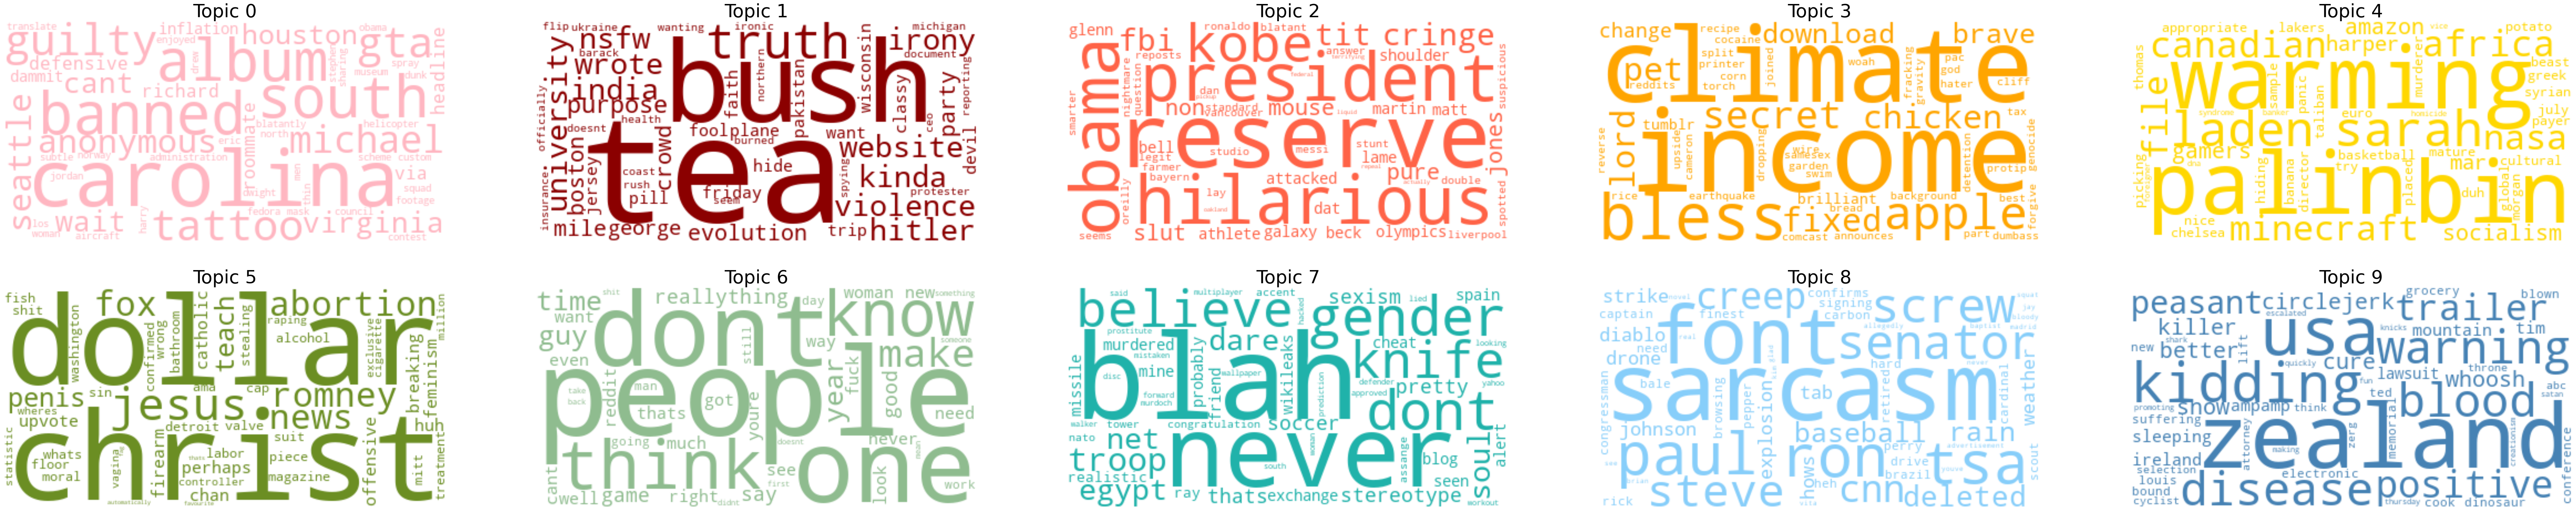

In [18]:
from wordcloud import WordCloud

topic_colors = ['lightpink', 'darkred', 'tomato', 'orange', 'gold', 'olivedrab', 'darkseagreen', 'lightseagreen', 'lightskyblue', 'steelblue']

topic_wordclouds = []

for i in range(num_topics):
    imp_words_topic=""
    comp=lda_model.components_[i]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
      imp_words_topic=imp_words_topic+" "+word[0]
    
    # Generate word cloud with the topic's color
    wordcloud = WordCloud(width=400, height=200, background_color='white', color_func=lambda *args, **kwargs: topic_colors[i]).generate(imp_words_topic)
    topic_wordclouds.append(wordcloud)

plt.figure(figsize=(100, 40))
for i, wordcloud in enumerate(topic_wordclouds):
    plt.subplot(4, 5, i+1) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Topic {}'.format(i),fontsize=40)
    plt.axis("off")

plt.show()